# Processing SuperSegger Output & Estimation of $\alpha$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mscl.plotting
import matlab.engine as matlab
import scipy
import tqdm
import glob
colors = mscl.plotting.set_plotting_style()
%matplotlib inline

In this notebook, we will show how the output is read from a SuperSegger `cell.mat` file, perform data validation, and estimate the calibration factor from a set of cell divisions.  To run this notebook, you must have installed IPython 4.0 and MATLAB 2017a or later.

## The Experiment

The goal of this experiment is to determine the absolute brightness (in arbitrary units) of a single fluorophore. The method to do that, as described in [Rosenfeld et al., 2005](), is to measure the fluorescence of a single mother scale over several divisions. The fluctuation in the intensity between two sister cells allows us to estimate the calibration factor $\alpha$ through the relation,

$$
\langle (I_1 - I_2)^2 \rangle = \alpha (I_1 + I_2) = \alpha I_\text{tot},
\tag{1}
$$

where $I_1$ and $I_2$ are the intensities of the two sister cells and $I_\text{tot}$ is the intensity of the mother cell. Eq. 1 is derived in detail in the accompanying notebook [estimating the calibration factor](http://science.sciencemag.org/content/307/5717/1962.long) where we also show the statistical analysis and error estimation. 

To make these measurements, cells were constructed which expressed a green fluorescent protein (sfGFP) molecule under the regulation of the TetR repressor. The expression of this protein is modulated by adding the TetR allosteric effector anhydro-tetracycline. Once this effector molecule is removed from the cell, further expression of the protein is ceased. Monitoring these cells over a period of time allows us to measure the partitioning of these proteins into the daughter cells. 

In this notebook, we will examine the intensity measurements of a single field of view containing a large number of cells. These cells were allowed to grow on a standard M9 Minimal Medium supplemented with 0.5% (w/v) glucose held at 37° C. These images were taken in phase contrast and fluorescence with a phase image taken every 5 minutes and a fluorescence image taken every 15 minutes for a total of three hours. Once the experiment was finished, the images were segmented and lineages were registered using the [open source software SuperSegger](http://mtshasta.phys.washington.edu/website/SuperSegger.php) from the [Paul Wiggins Lab](http://mtshasta.phys.washington.edu/website/) at the University of Washington. 

## Parsing the SuperSegger `cell` files

Once segmentation and lineage assembly is complete, SuperSegger saves its output in two different formats $-$ the `clist` file and the `cell` file. The `clist` file contains information about every cell division event including fluorescence, birth and death area, position, and if the daughter cells continued to divide or perished. A `cell` file, however, contains the information for a *single* cell across its entire lifetime (meaning it contains the same information as in the `clist` file, but at each frame). There is a single `cell` file for every single cell measured in the experiment.

At first glance, it would appear that the `clist` has everything that we need. However, as each cell has several fluorescence exposures, we must correct for photobleaching. This means that we must parse every `cell` file to figure out how many exposures each cell has had. 

The `cell` file is a MATLAB `.mat` file. These are best read through the MATLAB software, however we chose to do all of the analysis in Python for its ease of use and accessiblity. These `.mat` files can be read into Python using the `scipy.io` library, but the complex structure of the `cell` file makes parsing  the result much more difficult. MATLAB [has an API for Python](https://www.mathworks.com/help/matlab/matlab-engine-for-python.html), meaning that we can call an instance of MATLAB from the Python kernel, read in the `.mat` file, and return the data, convert it to a dictionary, and return the data to the Python interpreter. Below, we'll load one of these `cell` files and examine its contents.

In [2]:
# Define the path to the cell file.
cell = '../../data/test_data/xy02/cell/Cell0000017.mat'

# Instantiate the matlab engine.
eng = matlab.start_matlab()

# Assign a variable to the workspace containing the path. 
eng.workspace['f'] = cell

# Load in the file using matlab and return it to a Python variable.
ex_mat = eng.eval('load(f)')

The variable `ex_mat` is now a `dict` containing a swath of information regarding the cell in question. We can index this dictionary in the typical Python fashion to access this information.

In [3]:
# Print some information about the cell.
print('This cell was born on frame {0}.'.format(ex_mat['birth']))
print('This cell tragically perished on frame {0}.'.format(ex_mat['death']))
print('The mother of this cell is cell number {0}.'.format(ex_mat['motherID']))
print('This cell produced daughters with IDs {0} and {1}.'.format(ex_mat['daughterID'][0][0], 
                                                                  ex_mat['daughterID'][0][1]))

This cell was born on frame 1.0.
This cell tragically perished on frame 22.0.
The mother of this cell is cell number 0.0.
This cell produced daughters with IDs 236.0 and 237.0.


None of the above properties change with time, however. They are static summaries of the entire division. To access the frame-by-frame information, we must look at the dictionary `CellA` which is in the `ex_mat` dictionary. 

In [4]:
# Print information over time.
print('Intensity measurements for Cell {0} over time.'.format(ex_mat['ID']))
for i, t in enumerate(ex_mat['CellA']):
    value = t['fl1']['sum']
    frame_number = ex_mat['birth'] + i 
    print("frame {0} : {1:0.1f} [a. u.]".format(frame_number, value ))

Intensity measurements for Cell 17.0 over time.
frame 1.0 : 71652.0 [a. u.]
frame 2.0 : 0.0 [a. u.]
frame 3.0 : 0.0 [a. u.]
frame 4.0 : 0.0 [a. u.]
frame 5.0 : 85358.0 [a. u.]
frame 6.0 : 0.0 [a. u.]
frame 7.0 : 0.0 [a. u.]
frame 8.0 : 0.0 [a. u.]
frame 9.0 : 95125.0 [a. u.]
frame 10.0 : 0.0 [a. u.]
frame 11.0 : 0.0 [a. u.]
frame 12.0 : 0.0 [a. u.]
frame 13.0 : 60679.0 [a. u.]
frame 14.0 : 0.0 [a. u.]
frame 15.0 : 0.0 [a. u.]
frame 16.0 : 0.0 [a. u.]
frame 17.0 : 62689.0 [a. u.]
frame 18.0 : 0.0 [a. u.]
frame 19.0 : 0.0 [a. u.]
frame 20.0 : 0.0 [a. u.]
frame 21.0 : 79457.0 [a. u.]
frame 22.0 : 0.0 [a. u.]


It looks like this cell lived for twelve frames and was exposed with the excitation wavelength three times. All of the `0.0` measurements are frames which were not exposed. We notice that the last exposure (frame 13) is brighter than the first. This is likely due to the variation in our measurement rather than by gain of fluorescence (**CHECK THIS**).

Below we write a function which can read in a list of `cell` files and extract the relevant information.

In [21]:
def cell_to_dict(file, eng, add_props=None, excluded_props=None):
    """
    Reads a single cell file and produces a dictionary containing
    the properties of interest.

    The returned properties are
    * birth - frame number at which the cell was born.
    * death - frame number at which the cell died.
    * divide - bool for an observed cell division.
    * ID - integer ID number of the cell.
    * motherID - integer ID number of the mother cell.
    * sisterID - integer ID number of the sister cell.
    * birth_fluo - fluorescence value at the cell's birth.
    * death_fluo - fluorescence value at the cell's death.
    * daughter_1_ID - integer ID number of the first daughter.
    * daughter_2_ID - integer ID number of the second daughter.


    Parameters
    ----------
    file: str
        Path of the cell file. This must be in a `.mat` format.
    eng: MATLAB engine object
        Engine of running matlab session.
    add_props : dict, default None
        Dictionary of additional properties (not found in the mat file)
        to be included in the returned dictionary.
    excluded_props: list of str
        Properties of cell.mat file to be ignored. These must be
        exactly how they are defined in the cell file.

    Returns
    -------
    cell_dict : dictionary
        Dictionary of all extracted properties from the cell files.
    """

    # Ensure the supplied file is actually a .mat and other types are correct.
    if file.split('.')[-1] != 'mat':
        raise TypeError("supplied file {0} is not a `.mat` file.".format(file))
    if add_props is not None and type(add_props) is not dict:
        raise TypeError(
            "add_props is {0} and not dict.".format(type(add_props)))
    if excluded_props is not None and type(excluded_props) is not list:
        raise TypeError(
            "add_props must be list. Type is currently {0}.".format(type(excluded_props)))

    # Define the values of interest.
    vals = ['birth', 'death', 'divide', 'ID', 'motherID', 'sisterID',
            'daughter_1_ID', 'daughter_2_ID', 'birth_fluo', 'death_fluo', 'birth_area', 'death_area']

    # Load the mat file using MATLAB.
    eng.workspace['f'] = file
    mat = eng.eval('load(f)')

    # Assemble the dictionary for constant properties.
    cell_dict = {v: mat[v] for v in vals[:-6]}
    daughters = np.array(mat['daughterID'])

    # Determine  if daughters were produced. If not, change ID to NaN.
    if len(daughters) == 0:
        daughter_1, daughter_2 = None,  None
    else:
        daughter_1, daughter_2 = daughters[0]
    cell_dict['daughter_1_ID'] = daughter_1
    cell_dict['daughter_2_ID'] = daughter_2

    # Extract fluorescence information -- This is a bit gross but checked.
    try:
        fluo = [mat['CellA'][i]['fl1']['sum']
                for i, _ in enumerate(mat['CellA'])]
        nonzero = np.where(np.array(fluo) > 0)[0]
        num_exposures = len(nonzero)
        cell_dict['birth_fluo'] = fluo[nonzero.min()]
        cell_dict['death_fluo'] = fluo[nonzero.max()]
        cell_dict['birth_area'] = mat['CellA'][nonzero.min()]['coord']['A']
        cell_dict['death_area'] = mat['CellA'][nonzero.max()]['coord']['A']
    except:
        cell_dict['birth_fluo'] = 0
        cell_dict['death_fluo'] = 0
        cell_dict['birth_area'] = mat['CellA'][0]['coord']['A']
        cell_dict['death_area'] = mat['CellA'][-1]['coord']['A']
        num_exposures = 0
    cell_dict['num_exposures'] = num_exposures
    # Deal with exclusion and addition of props.
    if excluded_props is not None:
        new_dict = {}
        keys = cell_dict.keys()
        for key in keys:
            if key not in excluded_props:
                new_dict[key] = cell_dict[key]
        cell_dict = new_dict
    if add_props is not None:
        for key in add_props.keys():
            cell_dict[key] = add_props[key]

    # Return the cell dictionary.
    return cell_dict


def parse_cell_files(files, eng, verbose=False, **kwargs):
    """
    Executes cell_to_dict across a list of files and returns a Pandas DataFrame.
    """
    if type(files) is not list:
        raise TypeError("'files' is type {0} not list.".format(type(files)))
    if verbose:
        files = tqdm.tqdm(files)
    for i, f in enumerate(files):
        cell_dict = cell_to_dict(f, eng, **kwargs)
        if i == 0:
            keys = cell_dict.keys()
            df = pd.DataFrame([], columns=keys)
            df = df.append(cell_dict, ignore_index=True)
        else:
            df = df.append(cell_dict, ignore_index=True)
    return df


With these functions in hand, we can now read in all of the experimental data into a tidy DataFrame. We have multiple positions, so this will be done in a loop. 

In [22]:
# Get the paths to the positions 
positions = glob.glob('../../data/test_data/xy*')
dilution = []
for i, p in enumerate(positions): 
    # Get the paths to the cell files.
    files = glob.glob(p + '/cell/*.mat')
                      
    # Feed them into the parsing function.
    df = parse_cell_files(files, eng, verbose=True, add_props={'pos': i})
   
    # Append the dataframe to the list.
    dilution.append(df)

# Concatenate all of the dataframes together.
dilution = pd.concat(dilution)

# Look at some of the data.
dilution.head()


 16%|█▋        | 60/365 [00:02<00:13, 22.24it/s]


 31%|███       | 156/503 [00:06<00:15, 22.54it/s]


 38%|███▊      | 114/304 [00:05<00:08, 22.54it/s]


 67%|██████▋   | 270/402 [00:12<00:05, 22.30it/s]


100%|██████████| 402/402 [00:18<00:00, 22.31it/s]

 27%|██▋       | 129/477 [00:05<00:15, 22.41it/s]


100%|██████████| 477/477 [00:21<00:00, 22.50it/s]

 25%|██▍       | 114/460 [00:05<00:15, 22.26it/s]


 38%|███▊      | 114/301 [00:05<00:08, 22.34it/s]


 61%|██████▏   | 273/444 [00:12<00:07, 22.38it/s]


100%|██████████| 444/444 [00:19<00:00, 22.40it/s]

 74%|███████▍  | 291/394 [00:13<00:04, 22.24it/s]


100%|██████████| 321/321 [00:14<00:00, 22.16it/s]

  6%|▌         | 32/516 [00:01<00:24, 20.14it/s]


 96%|█████████▌| 495/516 [00:22<00:00, 21.84it/s]


100%|██████████| 516/516 [00:23<00:00, 21.86it/s]

 91%|█████████ | 441/484 [00:19<00:01, 22.17it/s]


100%|██████████| 484/484 [00:21<00:00, 22.19it/s]

,birth,death,divide,ID,motherID,sisterID,daughter_1_ID,daughter_2_ID,birth_fluo,death_fluo,birth_area,death_area,num_exposures,pos
0,14.0,16.0,0.0,117.0,0.0,0.0,NaN,NaN,0.0,0.0,89.0,34.0,0.0,0.0
1,11.0,25.0,1.0,103.0,21.0,104.0,220.0,221.0,97992.0,117126.0,76.0,77.0,4.0,0.0
2,34.0,37.0,0.0,315.0,162.0,316.0,NaN,NaN,66113.0,66113.0,45.0,45.0,1.0,0.0
3,33.0,37.0,0.0,301.0,165.0,302.0,NaN,NaN,58259.0,71744.0,40.0,52.0,2.0,0.0
4,34.0,37.0,0.0,329.0,143.0,330.0,NaN,NaN,65595.0,65595.0,57.0,57.0,1.0,0.0


We will also want to do this with the autofluorescence images. The autofluorescence data consist of single snapshots in phase contrast and fluorescence, so we can exclude a lot of properties. 

In [25]:
# Load the autofluorescence data.
files = glob.glob('../../data/test_data/autofluorescence/xy*/cell/*.mat')
auto = parse_cell_files(files, eng, excluded_props=['birth', 'death', 'divide', 'ID', 'motherID',
                                                   'sisterID', 'daughter_1_ID', 'daughter_2_ID',
                                                   'death_fluo', 'death_area', 'num_exposures'])
auto.head()

,birth_fluo,birth_area
0,60620.0,57.0
1,46052.0,53.0
2,56875.0,51.0
3,52079.0,60.0
4,51718.0,53.0


## Exploratory Data Analysis

With the data in hand, we can perform some sanity checks to validate our data. For example, we would expect the fluorescence distribution of all of cells on the first frame to be shifted relative to the autofluorescence intensity. We would also expect the fluorescence to be conserved. Here, we will look at some of these properties.

###  Expression Distributions and Conservation of Fluorescence

Both the autofluorescence and dilution strains were segmented and meaasured using the SuperSegger neural network. Prior to the segmentation, the images were flattened using knowledge of the illumination profile. Below, we compute the empirical cumulative distributions for the autofluorescence and founding cells. 

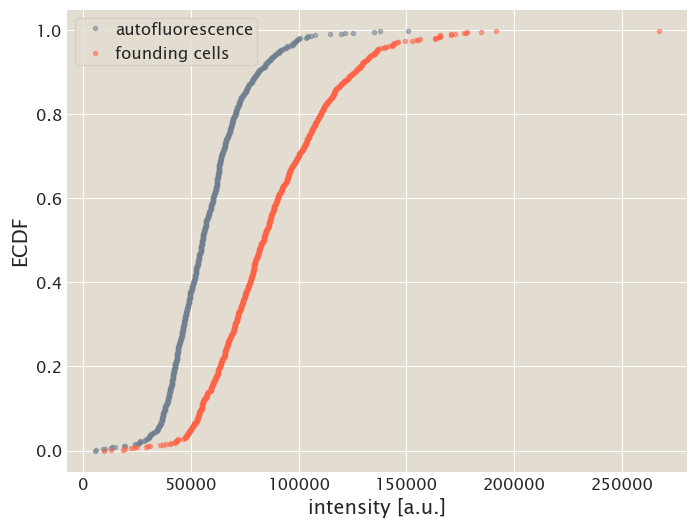

In [49]:
# Select only the cells present on the first frame
founders = dilution[dilution['birth']==1]


# Compute the ECDF
founder_x = np.sort(founders['birth_fluo'])
founder_y = np.arange(0, len(founders)) / len(founders)

# Do the same for the autofluorescence samples.
auto_x = np.sort(auto['birth_fluo'])
auto_y = np.arange(0, len(auto)) / len(auto)

# Set up the figure canvas.
fig, ax = plt.subplots(1,1)
ax.set_xlabel('intensity [a.u.]')
ax.set_ylabel('ECDF')

# Plot the ECDFs
_ = ax.plot(auto_x, auto_y, '.', color='slategray', alpha=0.5, label='autofluorescence')
_ = ax.plot(founder_x, founder_y, '.', color='tomato', alpha=0.5,
           label='founding cells')
_ = ax.legend()

The distribution for the dilution strain is shifted, although not by a lot. This could be a problem for the analysis and may require more cloning. Nevertheless, we'll continue with the processing. As some of the dilution strain signal comes from autofluorescence, we can subtract this from our DataFrame.

In [50]:
# Subtract the mean autofluorescence value from the dilution data.
mean_auto = np.mean(auto['birth_fluo'] / auto['birth_area'])
dilution['sub_birth'] = dilution['birth_fluo'] - (mean_auto * dilution['birth_area'])
dilution['sub_death'] = dilution['death_fluo'] - (mean_auto * dilution['death_area'])

If the experimental system is working as expected, the summed intensity of the daughter cell should be approximately equal to the intensity of the mother cell. Below, we look at our dilution DataFrame and take only the cells that divide, then compute the conservation of fluorescence.

In [55]:
# Isolate cells that divide.
producers = dilution[(dilution['divide']==1) | (dilution['death']==dilution['death'].unique().max())]

# Set up empty lists to save the mother intensity and daughter intensities.
mothers = []
daughters = []

# Because we have multiple positions, we will have to group by position and mother ID.
grouped = producers.groupby(['pos', 'motherID'])
for g, d in grouped:
    
    # Ensure that there are two daughter cells.
    if len(d) == 2:
        # Sum the death fluorescence of the two daughters.
        daughters.append(d['sub_birth'].sum())
        
        # Find the mother cell in the producer DataFrame.
        motherID = d['motherID'].unique()[0]
        mother = producers[(producers['pos']==g[0]) & (producers['ID']==motherID)]
        mothers.append(mother['sub_birth'].values[0]) 

Now we can plot the summed daughter intensities as a function of the mother intensity as well as the linear expectation. 

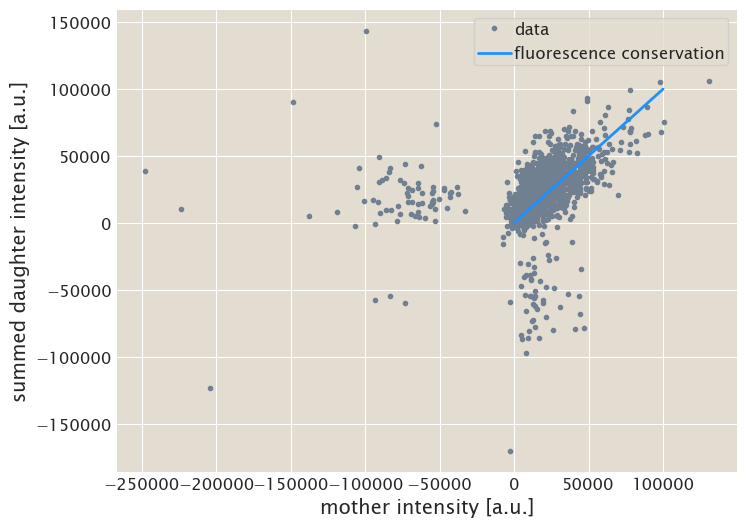

In [56]:
# Set up a vector of intensities
int_range = np.linspace(0, 1E5, 500)

# Define the figure canvas.
fig, ax = plt.subplots(1, 1)
ax.set_xlabel('mother intensity [a.u.]')
ax.set_ylabel('summed daughter intensity [a.u.]')

# Plot the data and expectation.
_ = ax.plot(mothers, daughters, '.', color='slategray', label='data')
_ = ax.plot(int_range, int_range, '-', color='dodgerblue', label='fluorescence conservation')
_ = ax.legend()

In [61]:
z = producers[producers['sub_birth'] > 0]
grouped = z.groupby(['pos', 'motherID'])
sq_diff = []
mom = []
i1 = []
i2 = []
for g, d in grouped:
    if len(d) == 2:
        i1.append(d.iloc[0]['sub_death'])
        i2.append(d.iloc[1]['sub_death'])
        _sq = np.diff(d['sub_birth'].values)**2
        _mom = producers[(producers['ID']==g[1]) & (producers['pos']==g[0])]['sub_death'].values[0]
        _mom = d['sub_death'].sum()
        sq_diff.append(_sq[0])
        mom.append(_mom)
        
i1 = np.array(i1)
i2 = np.array(i2)
i_tot = np.array(mom)

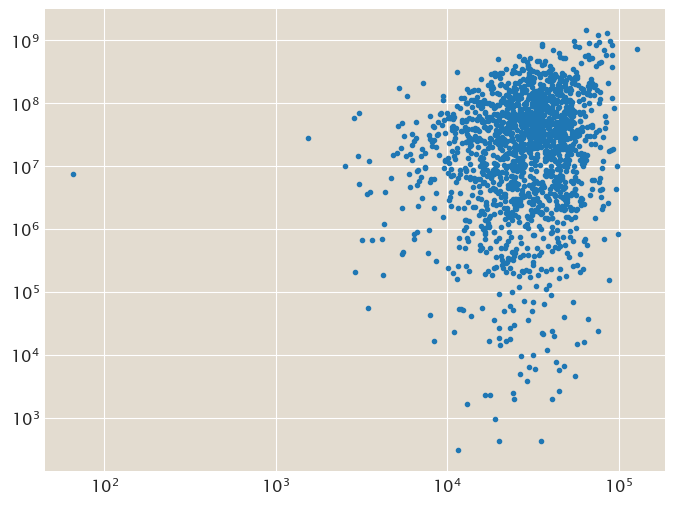

In [62]:
plt.loglog(mom, sq_diff, '.')

In [63]:
def deterministic_log_posterior(alpha, I_1, I_2, I_tot, neg=True):
    """
    Computes the log posterior of the deterministic solution to the estimation of the 
    calibration factor value.
    
    Parameters
    ----------
    alpha : float 
        The value of the calibration factor.
    I_1, I_2, I_tot : 1d-arrays or Pandas Series
        The intensity measurements of the daughter cells and the mother cell for a series of division events.
    neg : bool
        If True, the negative log posterior is returned. Default is True.
    
    Returns
    -------
    lp : float
        Value of the log posterior evaluated at the given value of alpha.
    """
    
    # Ensure that the intensity values are not negative.
    if (I_1 < 0).any() or (I_2 < 0).any():
        return ValueError('I_1 and I_2 must be positive.')
    
    # Ensure that alpha is positive.
    if alpha < 0:
        return -np.inf
    
    # Compute the binomial coefficient.
    n_1 = I_1 / alpha
    n_2 = I_2 / alpha
    n_tot = I_tot / alpha
    binom = scipy.special.gammaln(n_tot+1).sum() - scipy.special.gammaln(n_1+1).sum() -\
            scipy.special.gammaln(n_2+1).sum()
 
    # Compute the log posterior.
    lp = -len(I_1) * np.log(alpha) + binom - n_tot.sum() * np.log(2)
    
    # Determine if the negative log posterior should be returned.
    if neg is True:
        prefactor = -1
    else: 
        prefactor = 1
        
    return prefactor * lp

In [67]:
popt = scipy.optimize.minimize_scalar(deterministic_log_posterior, args=(i1, i2, i1 + i2, True))

TypeError: '<' not supported between instances of 'ValueError' and 'ValueError'

In [45]:
popt

     fun: 16437.417710558821
    nfev: 28
     nit: 27
 success: True
       x: 10904.001525813928

In [ ]:
ex_mat['CellA'][0].keys()

In [ ]:
ex_mat['CellA'][0]['coord']['A']